# Simulation of MYC Transcription Factor Network

This notebook simulates data and applies causal inference to a transcription 
factor network pulled from INDRA. The network is focused around the TF MYC.

The network was pulled such that there is interesting graphical topology that 
affects the analysis. To repull the network, see the `single_node.py` file.

In [65]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data
from MScausality.data_analysis.normalization import normalize

from MScausality.data_analysis.dataProcess import dataProcess

import pyro
import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pickle
import copy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Construct network

In [2]:
    # network = build_network(["MYC"], "gene", client, 
    #                         evidence_count=[85, 80, 70,50], levels=4,
    #                         upstream=True, downstream=[True, False, False, False])

In [14]:
def build_tf_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("LEP", "IL6")
    graph.add_edge("LEP", "STAT3")
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("LEP", "TNP")
    graph.add_edge("STAT3", "MYC")
    graph.add_edge("WNT3A", "CTNNB1")
    graph.add_edge("CTNNB1", "MYC")
    graph.add_edge("TNP", "CDKN1A")
    graph.add_edge("MYC", "CDKN1A")
    graph.add_edge("MYC", "TERT")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["LEP", "IL6", "STAT3", "TNP", "MYC", 
                 "WNT3A", "CTNNB1", "CDKN1A", "TERT"]
    obs_nodes = ["IL6", "STAT3", "MYC", "CTNNB1", "CDKN1A", "TERT"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

In [15]:
graph = build_tf_network()
y0_graph = build_admg(graph)

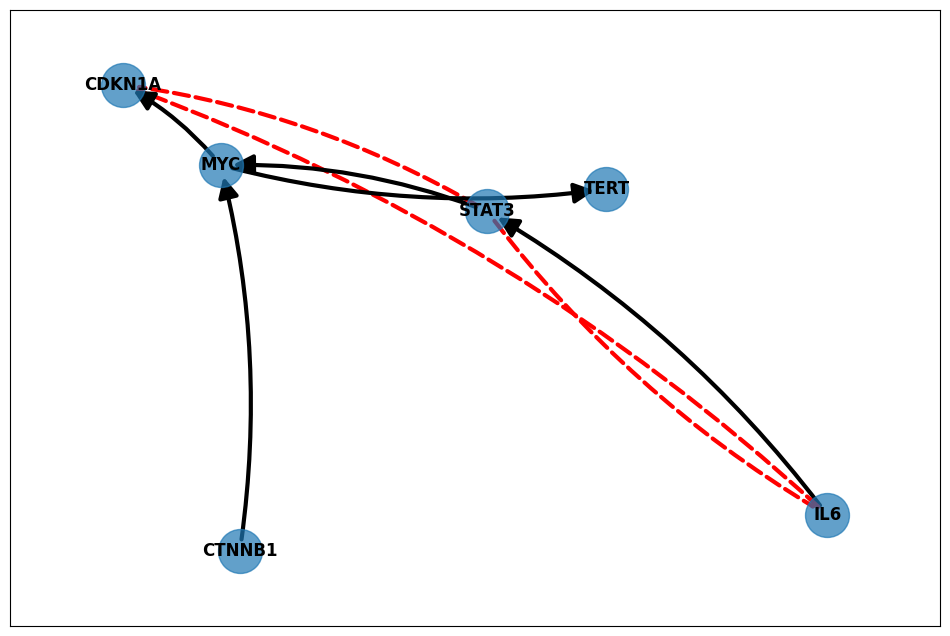

In [16]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph, figure_size=(12, 8))

In [18]:
query = Identification.from_expression(graph=y0_graph, query=P(Variable("MYC") @ Variable("STAT3")))
estimand = identify(query)
estimand


Sum[CTNNB1](P(MYC | CTNNB1, IL6, STAT3) * Sum[IL6, MYC, STAT3](Sum[CDKN1A, TERT](P(CDKN1A, CTNNB1, IL6, MYC, STAT3, TERT))))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [52]:
# ## Coefficients for relations
# myc_coef = {'LEP': {'intercept': 18., "error": 3},
#               'WNT3A': {'intercept': 17., "error": 3},
#               'IL6': {'intercept': 3, "error": 1, 
#                       'LEP': 0.6},
#               'CTNNB1': {'intercept': 5, "error": 1, 'WNT3A': .5},
#               'STAT3': {'intercept': 1.6, "error": 1, 
#                        'IL6': -0.5, 'LEP': 0.8},
#               'TNP': {'intercept': 2., "error": 1, 'LEP': 0.75},
#               'MYC': {'intercept': 2, "error": 1,
#                       'STAT3': 1., 'CTNNB1': -.2},
#               'CDKN1A': {'intercept': 3., "error": 1, 'MYC': 0.75, "TNP":.45},
#               'TERT': {'intercept': 4., "error": 1, 'MYC': 1.2}
#              }

## Coefficients for relations
myc_coef = {'LEP': {'intercept': 18., "error": .25},
              'WNT3A': {'intercept': 17., "error": .25},
              'IL6': {'intercept': 3, "error": .2, 
                      'LEP': 0.6},
              'CTNNB1': {'intercept': 5, "error": .2, 'WNT3A': .5},
              'STAT3': {'intercept': 1.6, "error": .2, 
                       'IL6': -0.5, 'LEP': 0.8},
              'TNP': {'intercept': 2., "error": .25, 'LEP': 0.75},
              'MYC': {'intercept': 2, "error": .25,
                      'STAT3': 1., 'CTNNB1': -.2},
              'CDKN1A': {'intercept': 3., "error": .25, 'MYC': 0.75, "TNP":.45},
              'TERT': {'intercept': 4., "error": .25, 'MYC': 1.2}
             }

In [53]:
def obs_gt_sim(coef, n):
    
    """
    Observational ground truth simulation of network
    """
    
    samples = dict()

    for key in coef.keys():
        eq_vals = coef[key]

        if len(eq_vals) > 2:
            samples[key] = eq_vals["intercept"] + np.sum(
                [eq_vals[reg]*samples[reg] for reg in eq_vals.keys() 
                 if reg not in ["intercept", "error"]], axis=0) + np.random.normal(
                     0, eq_vals["error"], n)
        else:
            samples[key] = np.random.normal(eq_vals["intercept"], eq_vals["error"], n)

    return samples

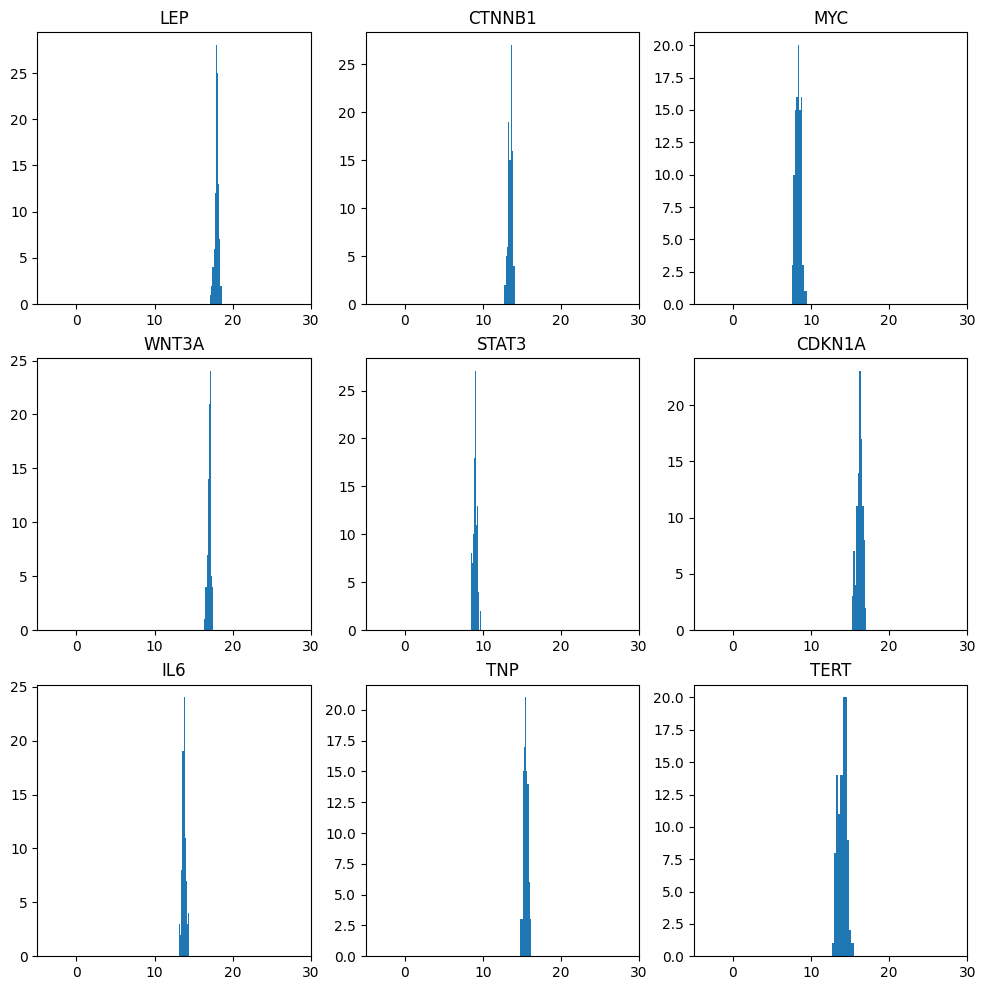

In [54]:
observational_data= obs_gt_sim(myc_coef, 100)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
t=0
for i in range(3):
    ax[0, i].hist(observational_data[list(observational_data.keys())[t]])
    ax[1, i].hist(observational_data[list(observational_data.keys())[t+1]])
    ax[2, i].hist(observational_data[list(observational_data.keys())[t+2]])

    ax[0, i].set_title(list(observational_data.keys())[t])
    ax[1, i].set_title(list(observational_data.keys())[t+1])
    ax[2, i].set_title(list(observational_data.keys())[t+2])

    ax[0, i].set_xlim(-5, 30)
    ax[1, i].set_xlim(-5, 30)
    ax[2, i].set_xlim(-5, 30)

    t+=3

In [55]:
def int_gt_sim(coef, n, protein_int_name, protein_int_value):

    """
    Ras interventional simulation of network (Ras=10 vs Ras=20)
    """
    
    samples = dict()

    for key in coef.keys():
        if key != protein_int_name:
            eq_vals = coef[key]

            if len(eq_vals) > 2:
                samples[key] = eq_vals["intercept"] + np.sum(
                    [eq_vals[reg]*samples[reg] for reg in eq_vals.keys() 
                    if reg not in ["intercept", "error"]], axis=0) + np.random.normal(
                        0, eq_vals["error"], n)
            else:
                samples[key] = np.random.normal(eq_vals["intercept"], eq_vals["error"], n)
        else:
            samples[protein_int_name] = np.repeat(protein_int_value, n)

    return samples

gt_int_IL6_low = int_gt_sim(myc_coef, 100000, "IL6", 15)
gt_int_IL6_high = int_gt_sim(myc_coef, 100000, "IL6", 10)

In [56]:
np.mean(gt_int_IL6_low["MYC"])

7.800391515694618

In [57]:
np.mean(gt_int_IL6_high["MYC"])

10.299567018373892

Ground Truth ACE:  2.5


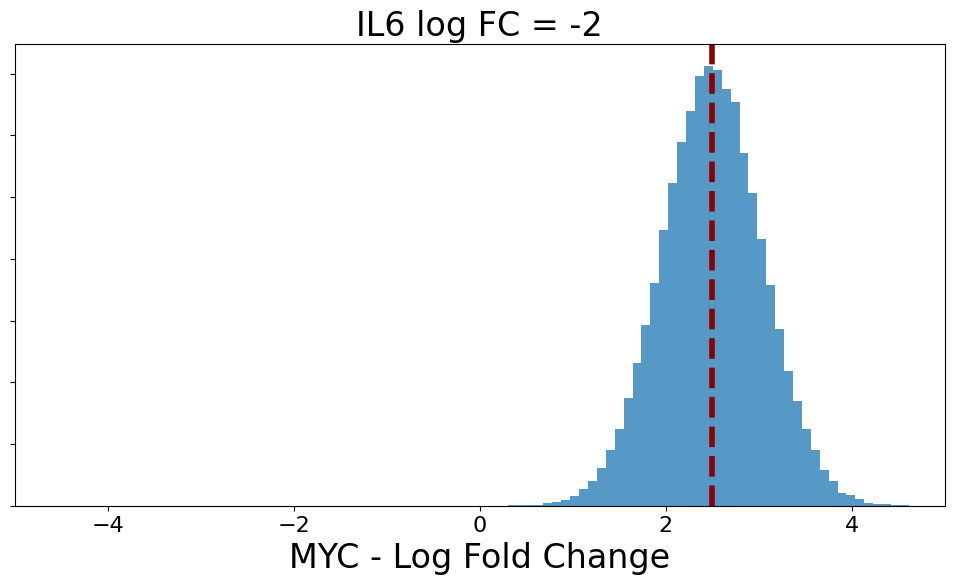

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"], bins=50, alpha=0.75, label="IL6=20")
ax.axvline((gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"]).mean(), color="darkred", linestyle="dashed", lw=4)
print("Ground Truth ACE: ", round(np.mean(gt_int_IL6_high["MYC"]) - np.mean(gt_int_IL6_low["MYC"]), 2))

ax.set_title("IL6 log FC = -2", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
ax.set_ylabel("")


ax.set_xlim(-5,5)
ax.set_yticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=16)

## Run inference

In [59]:
myc_sim = simulate_data(graph, coefficients=myc_coef, include_missing=True, 
                        mnar_missing_param=[-3, .4], cell_type=False, 
                        n_cells=3, n=100, seed=1)
myc_sim["Feature_data"].to_csv("../../data/MYC_pathway/feature_data_100_reps.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [62]:
# myc_sim_protein_data = pd.read_csv("../../data/MYC_pathway/protein_data_100_reps.csv")
myc_sim_protein_data = dataProcess(myc_sim["Feature_data"], normalization=False, MBimpute=False, sim_data=True) 
myc_sim_protein_data.head()

,LEP,WNT3A,IL6,TNP,CTNNB1,STAT3,MYC,CDKN1A,TERT
0,18.301583,16.644718,14.111531,15.995075,13.092027,8.883037,8.013800,16.062122,14.445210
1,18.329538,16.450521,14.238435,15.672531,13.079120,9.651143,9.164428,16.850340,15.007662
2,17.418820,16.744779,13.301732,14.893278,13.817388,9.174688,8.469274,15.384008,14.151446
3,17.681288,17.063646,14.255889,15.559474,13.888654,9.157067,8.398525,16.249232,14.393944
4,17.793690,16.725297,13.736487,14.919121,13.260889,8.855174,7.949299,15.833980,13.951614


(array([7.4, 7.6, 7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4]),
 [Text(0, 7.4, '7.4'),
  Text(0, 7.6000000000000005, '7.6'),
  Text(0, 7.800000000000001, '7.8'),
  Text(0, 8.0, '8.0'),
  Text(0, 8.200000000000001, '8.2'),
  Text(0, 8.4, '8.4'),
  Text(0, 8.600000000000001, '8.6'),
  Text(0, 8.8, '8.8'),
  Text(0, 9.0, '9.0'),
  Text(0, 9.200000000000001, '9.2'),
  Text(0, 9.4, '9.4')])

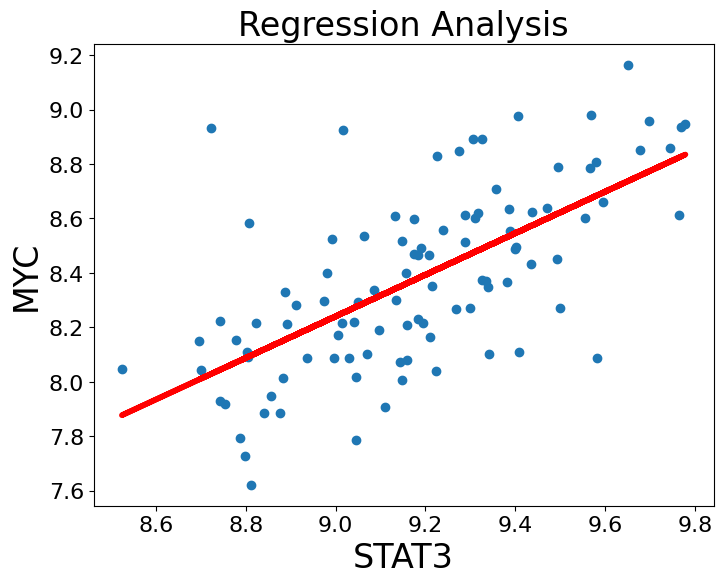

In [63]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = myc_sim_protein_data.loc[:, ["STAT3", "MYC"]].dropna()
x = plot_data["STAT3"]
y = plot_data["MYC"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("STAT3", size=24)
ax.set_ylabel("MYC", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Run model

In [68]:
input_data

,LEP,WNT3A,IL6,TNP,CTNNB1,STAT3,MYC,CDKN1A,TERT
0,1.410283,0.873734,0.053402,0.663357,-0.276748,-1.639763,-1.921252,0.685069,0.161458
1,1.419336,0.810846,0.094497,0.558907,-0.280928,-1.391024,-1.548639,0.940321,0.343599
2,1.124415,0.906137,-0.208839,0.306558,-0.041852,-1.545316,-1.773753,0.465473,0.066327
3,1.209410,1.009397,0.100150,0.522295,-0.018774,-1.551023,-1.796664,0.745662,0.144857
4,1.245810,0.899828,-0.068050,0.314927,-0.222065,-1.648786,-1.942139,0.611189,0.001615
...,...,...,...,...,...,...,...,...,...
95,1.291893,0.961565,0.022762,0.277496,-0.136072,-1.459928,-1.723908,0.794898,0.183304
96,1.306451,0.909176,0.124715,0.505441,-0.321451,-1.496303,-1.636856,0.825027,0.269200
97,1.260918,0.992807,-0.101058,0.424527,-0.205913,-1.592150,-1.896892,0.689843,0.034801
98,1.387482,1.002072,0.083119,0.638828,-0.129408,-1.460873,-1.785834,0.872484,0.140578


In [67]:
transformed_data = normalize(myc_sim_protein_data, wide_format=True)
input_data = transformed_data["df"]
scale_metrics = transformed_data["adj_metrics"]


pyro.clear_param_store()
lvm = LVM(input_data, 
          y0_graph)
lvm.prepare_graph()
lvm.prepare_data()
lvm.get_priors()
lvm.fit_model(num_steps=4000,
              patience=100, min_delta=5)

ValueError: at least one array or dtype is required

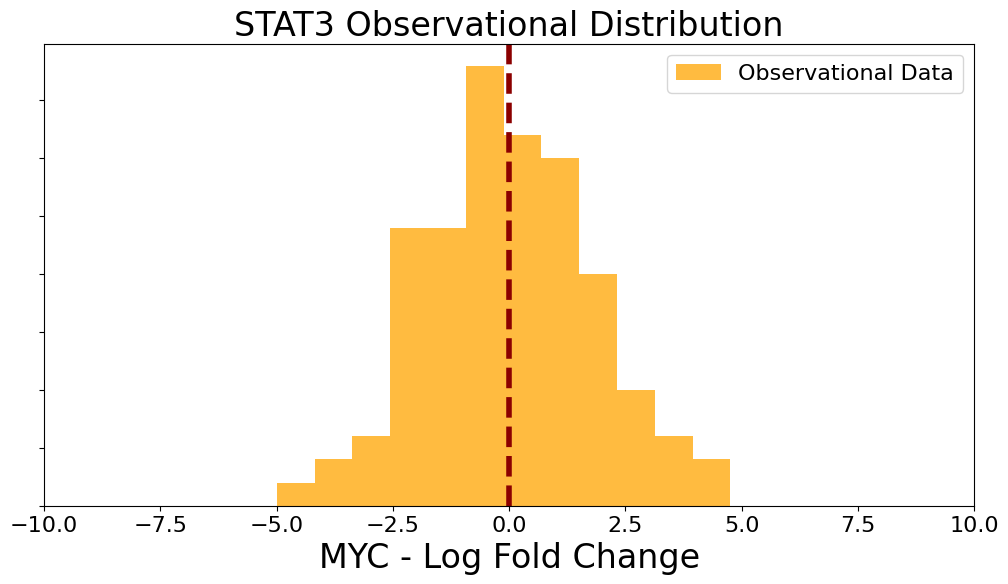

In [97]:
fig, ax = plt.subplots(figsize=(12,6))

# ax.hist(np.array(first_int), bins=30, alpha=.75, label="STAT3=10")
# ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
# sns.histplot(gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"], ax=ax2, 
#              kde=True, alpha=.01, color="grey",
#              label="Ground Truth")
ax.hist(myc_sim_protein_data["MYC"] - myc_sim_protein_data["MYC"].mean(), 
        bins=12, alpha=0.75, label="Observational Data", color="orange")
ax.axvline(0, color="darkred", linestyle="dashed", lw=4)

ax.legend(fontsize=16)
ax.set_title("STAT3 Observational Distribution", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
ax.set_ylabel("")


ax.set_xlim(-10,10)
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=16)
# plt.yticks(fontsize=20)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.hist(, bins=50, alpha=0.5, label="IL6=10")
# print("Ground Truth ACE: ", round(np.mean(gt_int_IL6_high["MYC"]) - np.mean(gt_int_IL6_low["MYC"]), 2))

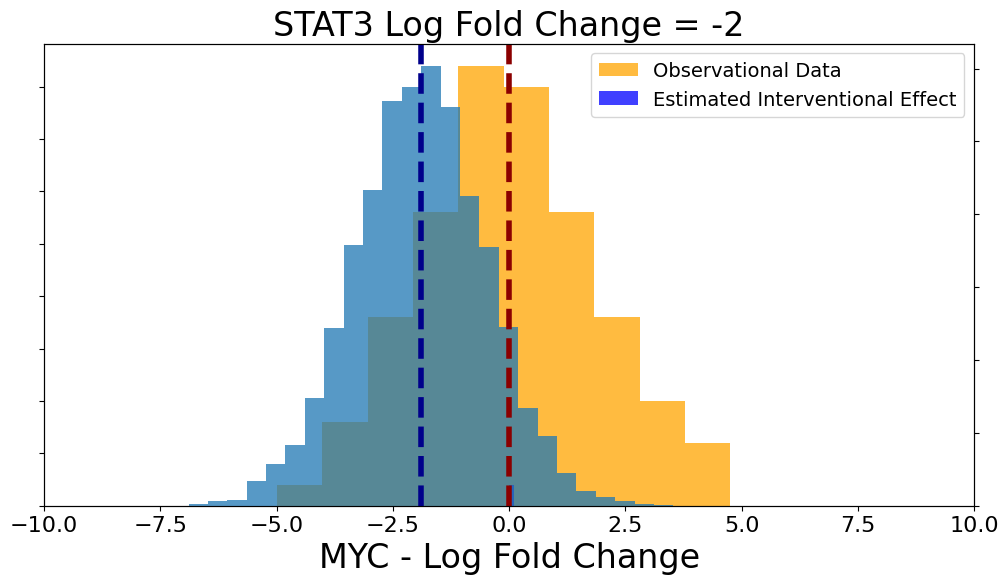

In [254]:
lvm.intervention("STAT3", "MYC", 10)
first_int = lvm.intervention_samples

lvm.intervention("STAT3", "MYC", 12)
second_int = lvm.intervention_samples

intervention_results = [first_int, second_int, lvm]

fig, ax = plt.subplots(figsize=(12,6))

# ax.hist(np.array(first_int), bins=30, alpha=.75, label="STAT3=10")
# ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax2 = ax.twinx()
# sns.histplot(gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"], ax=ax2, 
#              kde=True, alpha=.01, color="grey",
#              label="Ground Truth")
ax.hist(myc_sim_protein_data["MYC"] - myc_sim_protein_data["MYC"].mean(), 
        bins=10, alpha=0.75, label="Observational Data", color="orange")
ax.hist(0, 
        bins=10, alpha=0.75, label="Estimated Interventional Effect", color="blue")
ax2.axvline(0, color="darkred", linestyle="dashed", lw=4)

ax2.hist(np.array(first_int) - np.array(second_int), bins=25, alpha=.75, label="Estimated Interventional Effect")
ax2.axvline(np.mean(np.array(first_int) - np.array(second_int)), color="darkblue", linestyle="dashed", lw=4)

ax.legend(fontsize=14, loc="upper right")
ax.set_title("STAT3 Log Fold Change = -2", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
ax2.set_ylabel("")
ax.set_ylabel("")

ax.set_xlim(-10,10)
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=16)

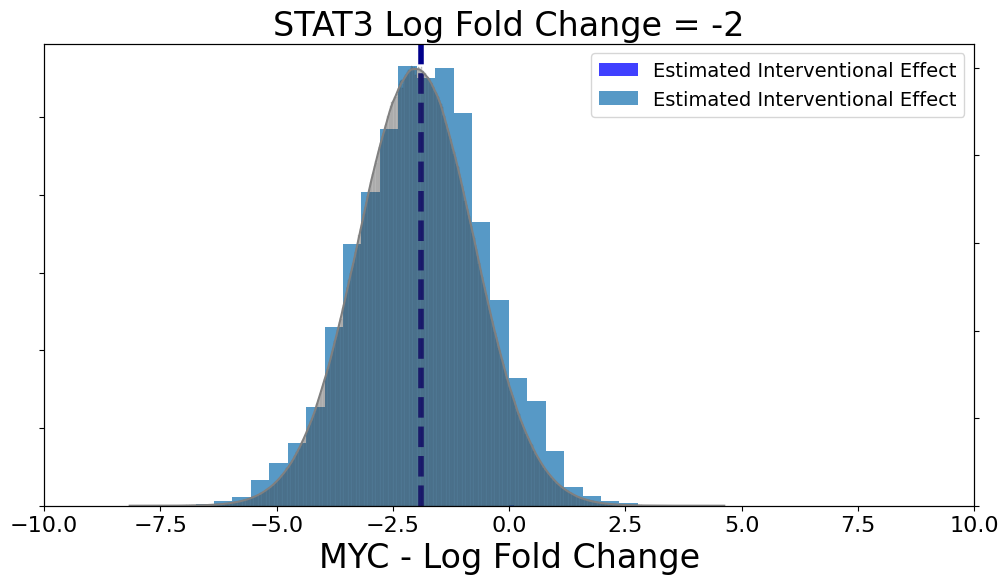

In [261]:
lvm.intervention("STAT3", "MYC", 10)
first_int = lvm.intervention_samples

lvm.intervention("STAT3", "MYC", 12)
second_int = lvm.intervention_samples

intervention_results = [first_int, second_int, lvm]

fig, ax = plt.subplots(figsize=(12,6))

# ax.hist(np.array(first_int), bins=30, alpha=.75, label="STAT3=10")
# ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax2 = ax.twinx()
sns.histplot(gt_int_IL6_low["MYC"]-gt_int_IL6_high["MYC"]+.5, ax=ax2, 
             kde=True, alpha=.25, color="grey",
             label="Ground Truth")
# ax.hist(myc_sim_protein_data["MYC"] - myc_sim_protein_data["MYC"].mean(), 
#         bins=10, alpha=0.75, label="Observational Data", color="orange")
ax.hist(0, 
        bins=10, alpha=0.75, label="Estimated Interventional Effect", color="blue")
# ax2.axvline(0, color="darkred", linestyle="dashed", lw=4)

ax.hist(np.array(first_int) - np.array(second_int), bins=25, alpha=.75, label="Estimated Interventional Effect")
ax.axvline(np.mean(np.array(first_int) - np.array(second_int)), color="darkblue", linestyle="dashed", lw=4)

ax.legend(fontsize=14, loc="upper right")
ax.set_title("STAT3 Log Fold Change = -2", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
ax2.set_ylabel("")
ax.set_ylabel("")

ax.set_xlim(-10,10)
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=16)

(-10.0, 10.0)

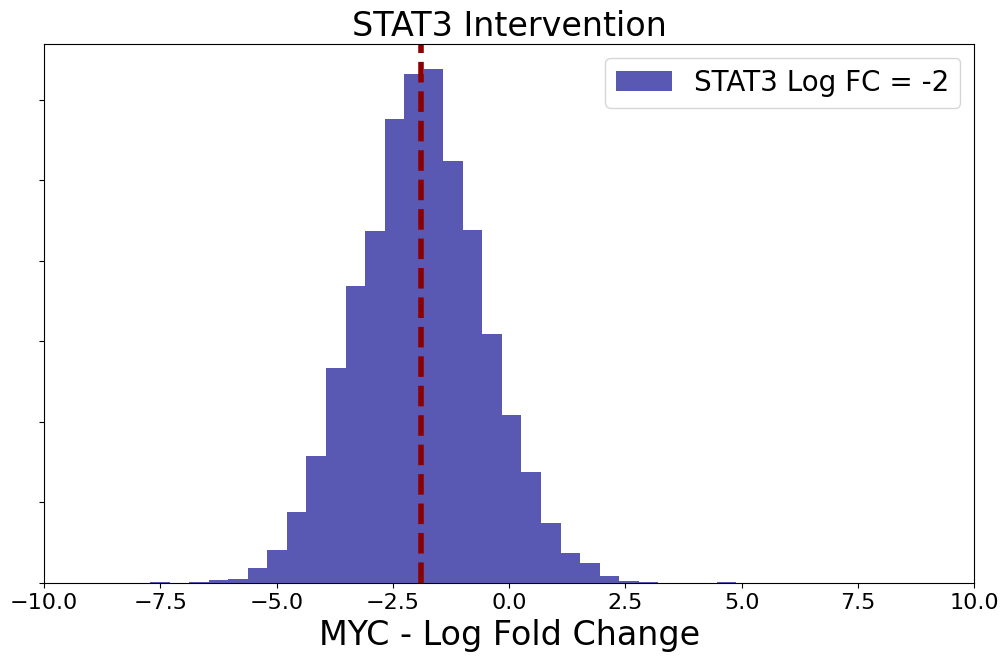

In [243]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(np.array(first_int) - np.array(second_int), color="darkblue",
        bins=30, alpha=.65, label="STAT3 Log FC = -2")
ax.axvline(np.mean(np.array(first_int) - np.array(second_int)), color="darkred", linestyle="dashed", lw=4)

# ax.axvline(np.mean(np.array(second_int) - np.array(first_int)), color="darkred", linestyle="dashed", lw=1)

# ax.axvline(np.mean(np.array(gt_int_IL6_high["MYC"]) - np.array(gt_int_IL6_low["MYC"])), 
#            color="darkblue", linestyle="dashed", lw=1)

ax.legend(fontsize=20)
ax.set_title("STAT3 Intervention", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
# ax.set_ylabel("MYC", size=24)
plt.xticks(fontsize=16)
ax.set_yticklabels([])
# ax2.set_yticks(fontsize=0)

ax.set_xlim(-10,10)


(-10.0, 10.0)

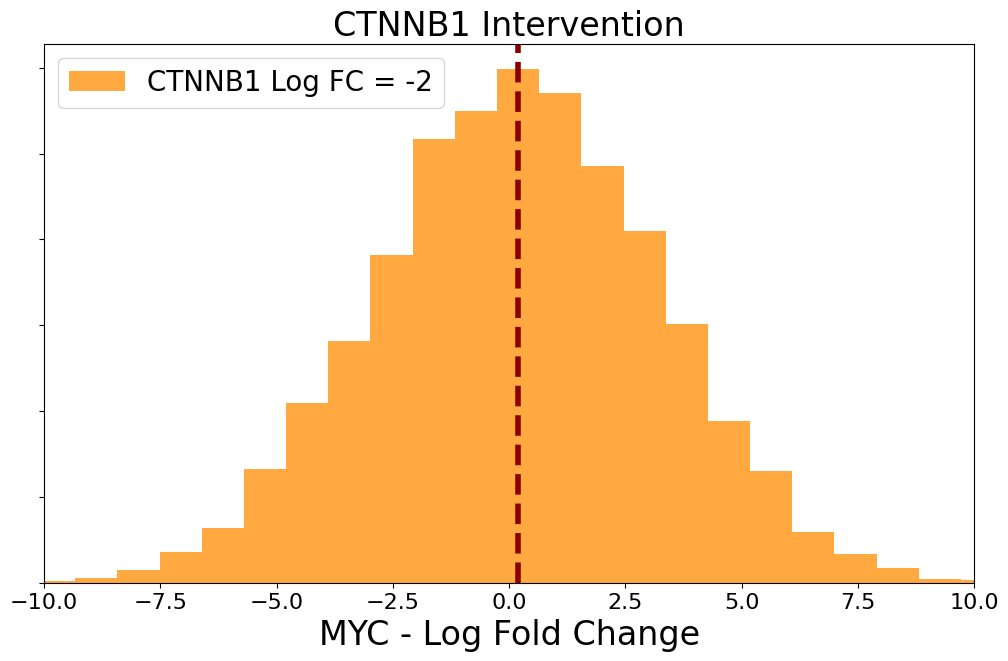

In [244]:
lvm.intervention("CTNNB1", "MYC", 10)
first_int = lvm.intervention_samples

lvm.intervention("CTNNB1", "MYC", 12)
second_int = lvm.intervention_samples

intervention_results = [first_int, second_int, lvm]

fig, ax = plt.subplots(figsize=(12, 7))

# ax.hist(np.array(first_int), bins=30, alpha=.75, label="STAT3=10")
# ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax.hist(np.array(first_int) - np.array(second_int), bins=25, color="darkorange", alpha=.75, label="CTNNB1 Log FC = -2")
ax.axvline(np.mean(np.array(first_int) - np.array(second_int)), color="darkred", linestyle="dashed", lw=4)

ax.legend(fontsize=20)
ax.set_title("CTNNB1 Intervention", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
# ax.set_ylabel("MYC", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_yticklabels([])

ax.set_xlim(-10,10)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.hist(, bins=50, alpha=0.5, label="IL6=10")
# ax2 = ax.twinx()
# ax2.hist(gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"], bins=50, alpha=0.5, label="IL6=20")
# print("Ground Truth ACE: ", round(np.mean(gt_int_IL6_high["MYC"]) - np.mean(gt_int_IL6_low["MYC"]), 2))

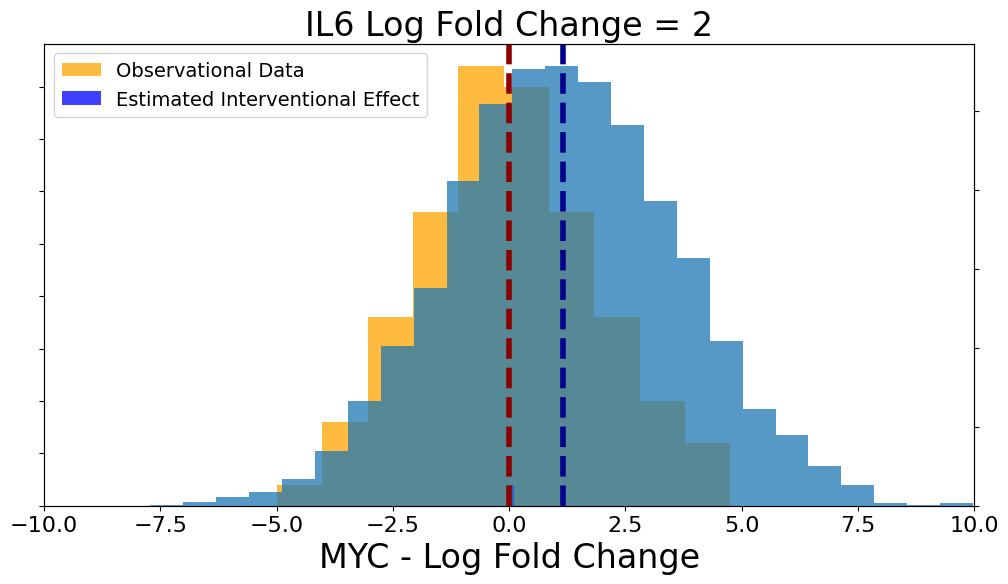

In [113]:
lvm.intervention("IL6", "MYC", 10)
first_int = lvm.intervention_samples

lvm.intervention("IL6", "MYC", 12)
second_int = lvm.intervention_samples

intervention_results = [first_int, second_int, lvm]

fig, ax = plt.subplots(figsize=(12,6))

# ax.hist(np.array(first_int), bins=30, alpha=.75, label="STAT3=10")
# ax.axvline(np.mean(np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)
ax2 = ax.twinx()
# sns.histplot(gt_int_IL6_high["MYC"] - gt_int_IL6_low["MYC"], ax=ax2, 
#              kde=True, alpha=.01, color="grey",
#              label="Ground Truth")
ax.hist(myc_sim_protein_data["MYC"] - myc_sim_protein_data["MYC"].mean(), 
        bins=10, alpha=0.75, label="Observational Data", color="orange")
ax.hist(0, 
        bins=10, alpha=0.75, label="Estimated Interventional Effect", color="blue")
ax2.axvline(0, color="darkred", linestyle="dashed", lw=4)

ax2.hist(np.array(second_int) - np.array(first_int), bins=25, alpha=.75, label="Estimated Interventional Effect")
ax2.axvline(np.mean(np.array(second_int) - np.array(first_int)), color="darkblue", linestyle="dashed", lw=4)

ax.legend(fontsize=14, loc="upper left")
ax.set_title("IL6 Log Fold Change = 2", size=24)
ax.set_xlabel("MYC - Log Fold Change", size=24)
ax2.set_ylabel("")
ax.set_ylabel("")

ax.set_xlim(-10,10)
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=16)

## Missing value imputation

In [257]:
high_missing_data = simulate_data(graph, coefficients=myc_coef, 
                                  include_missing=True, 
                                  mar_missing_param=.1, mnar_missing_param=[-7, .4], 
                                  n=300, seed=2)
high_missing_data["Feature_data"].to_csv("../../data/MYC_pathway/high_missing_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [200]:
high_missing_protein_data = pd.read_csv("../../data/MYC_pathway/high_missing_protein_data.csv")
high_missing_protein_data.head()

,originalRUN,CDKN1A,CTNNB1,IL6,LEP,MYC,STAT3,TERT,TNP,WNT3A
0,0,14.981299,13.412918,13.168043,17.480114,11.153887,NaN,16.457212,14.313733,19.750300
1,1,18.019417,14.573303,13.132060,18.563402,NaN,NaN,13.540477,15.316057,18.916138
2,2,13.991872,11.665207,9.365305,12.323615,NaN,NaN,12.632951,NaN,NaN
3,3,22.270326,NaN,14.714333,23.653015,15.100492,12.731592,19.332522,19.204767,NaN
4,5,13.338826,12.813428,NaN,16.206961,NaN,8.548993,14.059272,NaN,16.936924


In [201]:
high_missing_protein_data.loc[((high_missing_protein_data["MYC"] < 12) & (-np.isnan(high_missing_protein_data["STAT3"]))), "MYC"] = np.nan

(array([11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ]),
 [Text(0, 11.5, '11.5'),
  Text(0, 12.0, '12.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 13.0, '13.0'),
  Text(0, 13.5, '13.5'),
  Text(0, 14.0, '14.0'),
  Text(0, 14.5, '14.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 15.5, '15.5'),
  Text(0, 16.0, '16.0')])

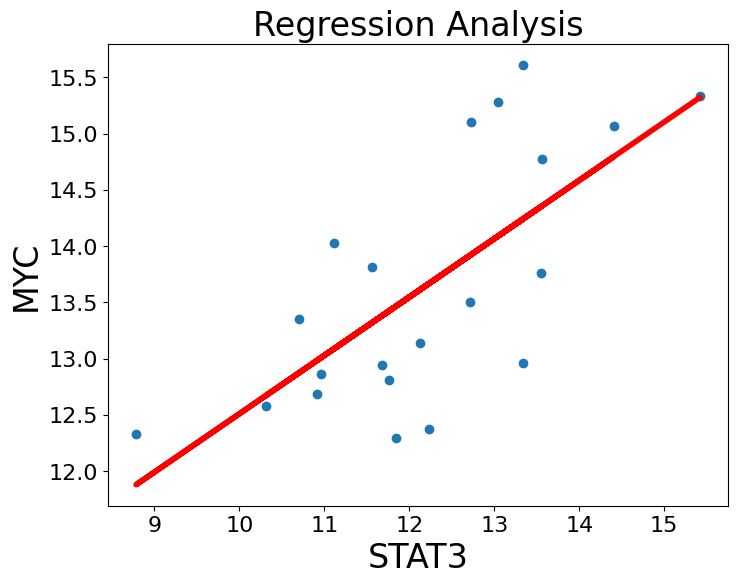

In [202]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = high_missing_protein_data.loc[:, ["MYC", "STAT3"]].dropna()
x = plot_data["STAT3"]
y = plot_data["MYC"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("STAT3", size=24)
ax.set_ylabel("MYC", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Text(0, 0.5, 'Percent Missing Replicates')

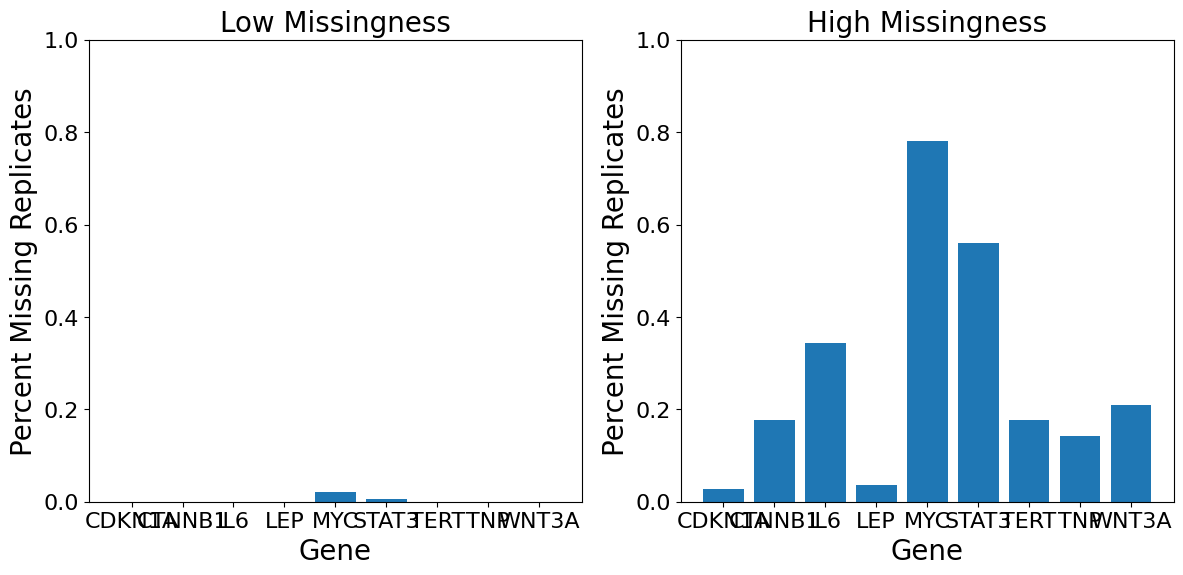

In [203]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].bar(x = myc_sim_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index,
          height=myc_sim_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(myc_sim_protein_data))

ax[1].bar(x = high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index, 
       height=high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_missing_protein_data))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_title("Low Missingness", size=20)
ax[1].set_title("High Missingness", size=20)

ax[0].set_xlabel("Gene", size=20)
ax[1].set_xlabel("Gene", size=20)

ax[0].set_ylabel("Percent Missing Replicates", size=20)
ax[1].set_ylabel("Percent Missing Replicates", size=20)

In [204]:
pyro.clear_param_store()
high_missing_lvm = LVM(
    high_missing_protein_data.iloc[:,1:], 
    y0_graph)
high_missing_lvm.prepare_graph()
high_missing_lvm.prepare_data()
high_missing_lvm.fit_model(num_steps=4000)

high_missing_lvm.intervention("STAT3", "MYC", 10)
first_int = high_missing_lvm.intervention_samples

high_missing_lvm.intervention("STAT3", "MYC", 20)
second_int = high_missing_lvm.intervention_samples

high_missing_intervention_results = [first_int, second_int, high_missing_lvm]

starting training
139167.64553897642
27811.854467511177
25997.87482947111
25279.24076396227
24753.914251625538
24386.082479953766
24070.562780678272
23863.14564090967
23678.27204233408
23546.211010098457
23349.72209149599
23230.49188488722
23156.31444299221
23037.705363959074
22883.40630438924
22749.983458310366
22729.946262717247
22722.585052073002
22646.035644978285
22571.461394667625
22519.22716602683
22458.797730326653
22418.36013111472
22450.29876998067
22364.792421847582
22374.794014006853
22382.400930315256
22363.682181328535
22400.834179654717
22286.056792616844
22266.12698534131
22294.868274599314
22251.77972072363
22280.697152391076
22273.57959255576
22303.361839562654
22249.554166138172
22237.594286486506
22219.589347988367
22171.688536912203


Text(0.5, 0, 'MYC - Log Intensity')

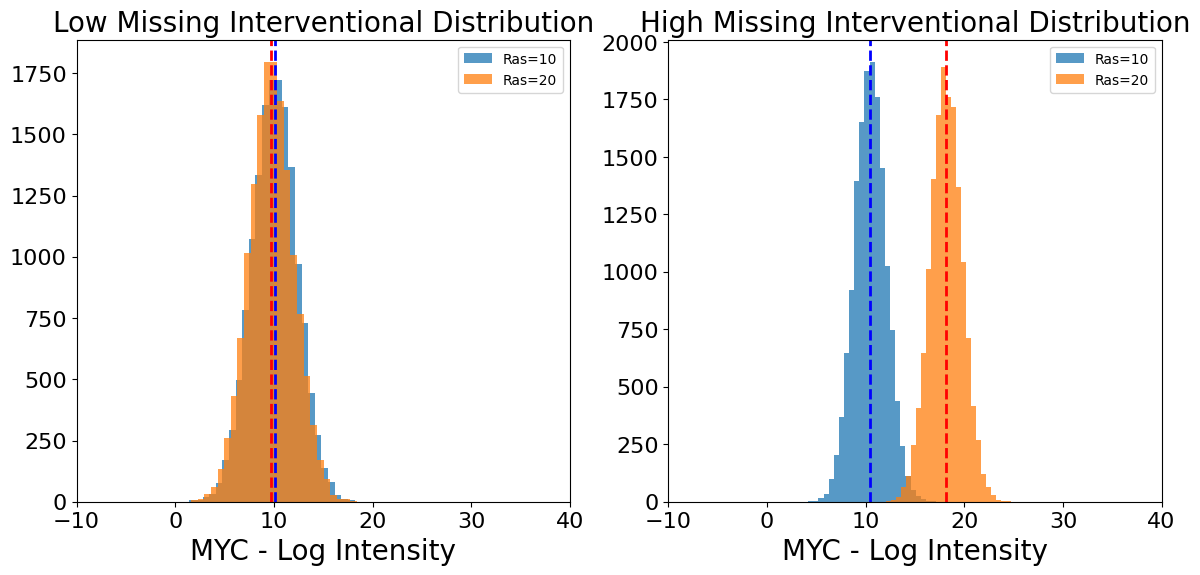

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[0].hist(intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[0].axvline(x=intervention_results[0].mean(), color="Blue", lw=2, linestyle="--")
ax[0].axvline(x=intervention_results[1].mean(), color="Red", lw=2, linestyle="--")
ax[0].legend()

ax[1].hist(high_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=25)
ax[1].hist(high_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=25)
ax[1].axvline(x=high_missing_intervention_results[0].mean(), color="Blue", lw=2, linestyle="--")
ax[1].axvline(x=high_missing_intervention_results[1].mean(), color="Red", lw=2, linestyle="--")
ax[1].legend()

ax[0].set_xlim(-10,40)
ax[1].set_xlim(-10,40)

plt.legend()

ax[0].set_title("Low Missing Interventional Distribution", size=20)
ax[0].set_xlabel("MYC - Log Intensity", size=20)

ax[1].set_title("High Missing Interventional Distribution", size=20)
ax[1].set_xlabel("MYC - Log Intensity", size=20)

# # ax.set_ylabel("Erk", size=24)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Compare imputed values

In [206]:
def format_int_data(df, p1, p2):
    df.loc[:, "full_int"] = np.where(np.isnan(df["imp_mean"]),
                                        df["intensity"], df["imp_mean"])

    p1_df = df.loc[df["protein"] == p1, ["intensity", "full_int"]]
    p1_df.loc[:, "imp_{0}".format(p1)] = np.isnan(p1_df["intensity"])
    p1_df.loc[:, p1] = p1_df.loc[:, "intensity"]
    p1_df.loc[:, "full_{0}".format(p1)] = p1_df.loc[:, "full_int"]

    p2_df = df.loc[df["protein"] == p2, ["intensity", "full_int"]]
    p2_df.loc[:, "imp_{0}".format(p2)] = np.isnan(p2_df["intensity"])
    p2_df.loc[:, p2] = p2_df.loc[:, "intensity"]
    p2_df.loc[:, "full_{0}".format(p2)] = p2_df.loc[:, "full_int"]


    df = pd.concat([p1_df.loc[:, [p1, 
                                  "full_{0}".format(p1),
                                  "imp_{0}".format(p1)]].reset_index(drop=True), 
                    p2_df.loc[:, [p2, 
                                  "full_{0}".format(p2),
                                  "imp_{0}".format(p2)]].reset_index(drop=True)], 
                    axis=1)
    return df

high_missing_plot_df = format_int_data(high_missing_intervention_results[2].imputed_data, "MYC", "STAT3")
low_missing_plot_df = format_int_data(intervention_results[2].imputed_data, "MYC", "STAT3")

In [207]:
low_missing_lm = linear_model.LinearRegression()
x = low_missing_plot_df.dropna()[["STAT3"]]
y = low_missing_plot_df.dropna()[["MYC"]]
low_missing_lm.fit(x, y)

low_missing_imp_lm = linear_model.LinearRegression()
x = low_missing_plot_df[["full_STAT3"]]
y = low_missing_plot_df[["full_MYC"]]
low_missing_imp_lm.fit(x, y)

high_missing_lm = linear_model.LinearRegression()
x = high_missing_plot_df.dropna()[["STAT3"]]
y = high_missing_plot_df.dropna()[["MYC"]]
high_missing_lm.fit(x, y)

high_missing_imp_lm = linear_model.LinearRegression()
x = high_missing_plot_df[["full_STAT3"]]
y = high_missing_plot_df[["full_MYC"]]
high_missing_imp_lm.fit(x, y)

LinearRegression()

Text(0, 0.5, 'MYC')

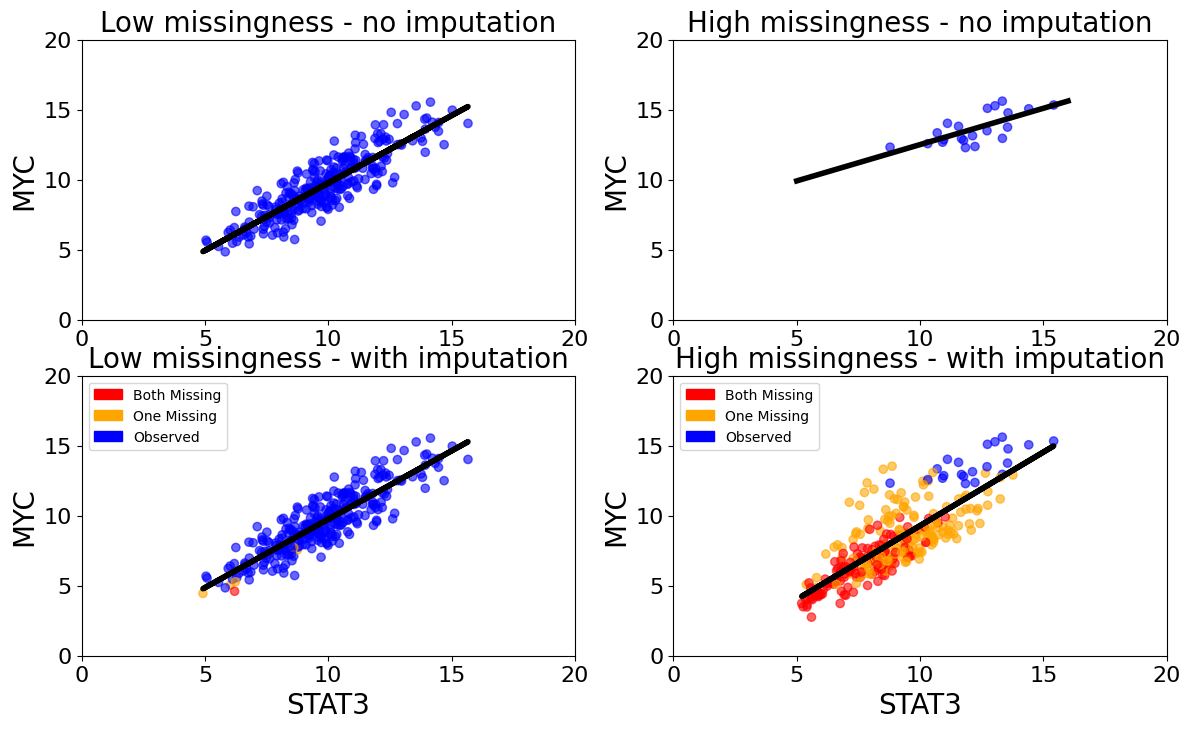

In [208]:
## Plot
fig, ax = plt.subplots(2, 2, figsize=(14,8))

colors1 = np.where((low_missing_plot_df["imp_MYC"] == True) & \
                   (low_missing_plot_df["imp_STAT3"] == True), "Red", 
                  np.where((low_missing_plot_df["imp_MYC"] == True) | \
                           (low_missing_plot_df["imp_STAT3"] == True), "Orange", "Blue"))

colors2 = np.where((high_missing_plot_df["imp_MYC"] == True) & \
                   (high_missing_plot_df["imp_STAT3"] == True), "Red", 
                  np.where((high_missing_plot_df["imp_MYC"] == True) | \
                           (high_missing_plot_df["imp_STAT3"] == True), "Orange", "Blue"))

ax[0,0].scatter(low_missing_plot_df["STAT3"], low_missing_plot_df["MYC"], c=colors1, alpha=.6)
ax[0,0].plot(low_missing_plot_df["STAT3"], 
           low_missing_lm.coef_[0]*low_missing_plot_df["STAT3"] + low_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,0].scatter(low_missing_plot_df["full_STAT3"], low_missing_plot_df["full_MYC"], 
              c=colors1, alpha=.6)
ax[1,0].plot(low_missing_plot_df["full_STAT3"], 
           low_missing_imp_lm.coef_[0]*low_missing_plot_df["full_STAT3"] + low_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

ax[0,1].scatter(high_missing_plot_df["STAT3"], high_missing_plot_df["MYC"], 
              c=colors2, alpha=.6)
ax[0,1].plot(np.arange(5,17), 
           high_missing_lm.coef_[0]*np.arange(5,17) + high_missing_lm.intercept_[0], 
           color="black", lw=4)

ax[1,1].scatter(high_missing_plot_df["full_STAT3"], high_missing_plot_df["full_MYC"], 
              c=colors2, alpha=.6)
ax[1,1].plot(high_missing_plot_df["full_STAT3"], 
           high_missing_imp_lm.coef_[0]*high_missing_plot_df["full_STAT3"] + high_missing_imp_lm.intercept_[0], 
           color="black", lw=4)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1,1].legend(handles=[red_patch, orange_patch, blue_patch])
ax[1,0].legend(handles=[red_patch, orange_patch, blue_patch])

ax[0,0].set_xlim(0,20)
ax[1,1].set_xlim(0,20)
ax[0,1].set_xlim(0,20)
ax[1,0].set_xlim(0,20)
ax[0,0].set_ylim(0,20)
ax[1,1].set_ylim(0,20)
ax[0,1].set_ylim(0,20)
ax[1,0].set_ylim(0,20)

ax[0,0].set_title("Low missingness - no imputation", size=20)
ax[1,1].set_title("High missingness - with imputation", size=20)
ax[1,0].set_title("Low missingness - with imputation", size=20)
ax[0,1].set_title("High missingness - no imputation", size=20)

ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,1].set_xlabel("STAT3", size=20)
ax[1,0].set_xlabel("STAT3", size=20)

ax[0,0].set_ylabel("MYC", size=20)
ax[0,1].set_ylabel("MYC", size=20)
ax[1,1].set_ylabel("MYC", size=20)
ax[1,0].set_ylabel("MYC", size=20)

## Test other ML methods

In [41]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_validate

In [32]:
myc_sim_protein_data.head()

,originalRUN,CDKN1A,CTNNB1,IL6,LEP,MYC,STAT3,TERT,TNP,WNT3A
0,0,19.628701,16.220750,15.429706,22.468321,11.962258,13.934370,16.630116,18.695142,23.189134
1,1,14.459347,12.098472,12.972846,15.760015,9.815250,8.182938,15.468241,14.314990,12.578313
2,2,15.798020,12.599483,11.676077,16.010769,9.207679,9.072689,15.364352,14.910910,14.501268
3,3,15.982628,12.253814,11.129359,14.376379,8.514989,10.172678,12.776435,13.817769,14.350051
4,4,17.096110,13.028473,13.675179,20.191507,11.185610,11.046483,16.268359,17.397950,16.154491


In [33]:
complete_set = myc_sim_protein_data.dropna()
X = complete_set.loc[:,["CDKN1A", "CTNNB1", "IL6", 
                                "LEP", "STAT3", 
                                "TERT", "TNP", "WNT3A"]]
y = complete_set["MYC"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Linear Regression

In [48]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [52]:
dict(
    zip(["CDKN1A", "CTNNB1", "IL6", 
         "LEP", "STAT3", 
         "TERT", "TNP", "WNT3A"], 
     
    lm.coef_)
)

{'CDKN1A': 0.24113110520105963,
 'CTNNB1': -0.07757650426157986,
 'IL6': 0.035859514012426125,
 'LEP': 0.008060172196311027,
 'STAT3': 0.324589134426112,
 'TERT': 0.4010622768942468,
 'TNP': -0.14097397520792548,
 'WNT3A': 0.0035009423347411965}

### Random Forest

In [34]:
rf = RandomForestRegressor()
cv_results = cross_validate(rf, X_train, y_train, cv=5)

In [35]:
cv_results

{'fit_time': array([0.12528706, 0.11118484, 0.29142499, 0.11667609, 0.11179185]),
 'score_time': array([0.00489569, 0.00384998, 0.00378609, 0.0038321 , 0.00344086]),
 'test_score': array([0.90967586, 0.93223834, 0.89417894, 0.92188767, 0.87593281])}

In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
np.sqrt(np.mean((y_test - rf.predict(X_test))**2))

0.5861895550874988

In [40]:
dict(
    zip(["CDKN1A", "CTNNB1", "IL6", 
         "LEP", "STAT3", 
         "TERT", "TNP", "WNT3A"], 
         rf.feature_importances_)
    )

{'CDKN1A': 0.03936118137109212,
 'CTNNB1': 0.008803082465248678,
 'IL6': 0.006037863498639554,
 'LEP': 0.005781562924087602,
 'STAT3': 0.07081207532346341,
 'TERT': 0.8558141162841801,
 'TNP': 0.0065500874321660655,
 'WNT3A': 0.006840030701122297}

In [339]:
X_test.columns

Index(['CDKN1A', 'CTNNB1', 'IL6', 'LEP', 'STAT3', 'TERT', 'TNP', 'WNT3A'], dtype='object')

<Axes: >

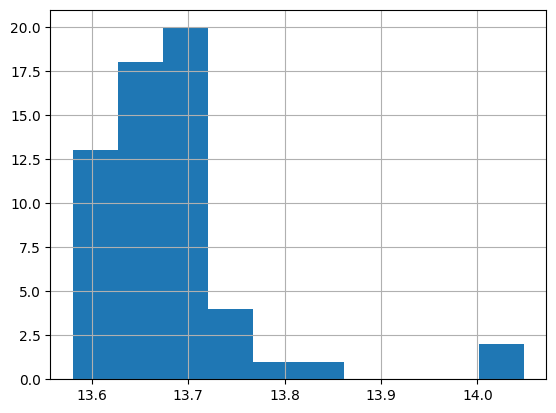

In [345]:
test=X_test
test.loc[:, "TERT"] = 20
pd.Series(rf.predict(test)).hist()

In [323]:
test = pd.DataFrame()

for col in X_test.columns:
    if col != "STAT3":
        test.loc[:, col] = np.random.uniform(0, 20, 10000)
    else:
        test.loc[:, "STAT3"] = np.repeat(10, 10000)

In [325]:
len(rf.predict(test))

10000

<Axes: >

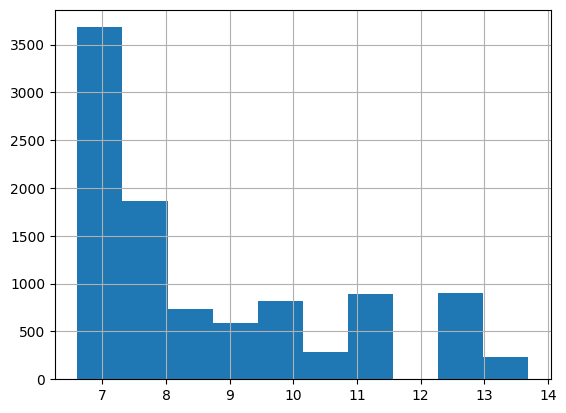

In [326]:
pd.Series(rf.predict(test)).hist()

<Axes: >

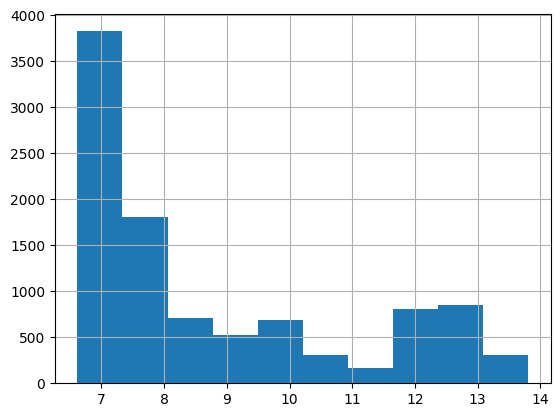

In [327]:
test = pd.DataFrame()

for col in X_test.columns:
    if col != "STAT3":
        test.loc[:, col] = np.random.uniform(0, 20, 10000)
    else:
        test.loc[:, "STAT3"] = np.repeat(20, 10000)

pd.Series(rf.predict(test)).hist()

### XGBoost

In [45]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

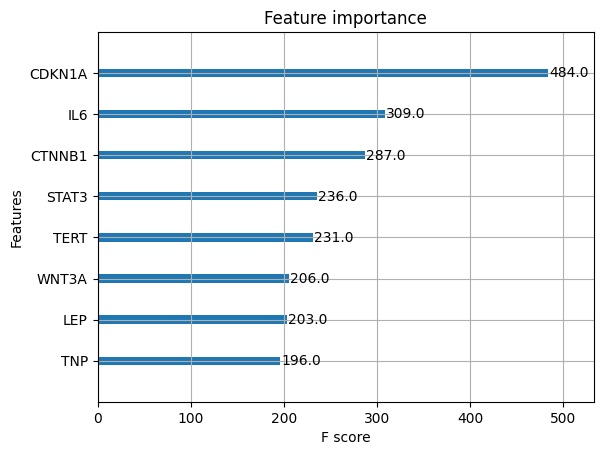

In [47]:
xgb.plot_importance(model)

### NN

In [347]:
from sklearn.neural_network import MLPRegressor ## TODO: Replace with something better (but simple prob.. Keras?)

In [381]:
myc_sim_high_rep = simulate_data(graph, coefficients=myc_coef, include_missing=True, 
                        mnar_missing_param=[-3, .4], cell_type=False, 
                        n_cells=3, n=10000, seed=1)
myc_sim_high_rep["Feature_data"].to_csv("../../data/MYC_pathway/high_rep_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [142]:
protein_data_high_rep = pd.read_csv("../../data/MYC_pathway/protein_data.csv")

In [110]:
complete_set = protein_data_high_rep.dropna()
X = complete_set.loc[:,["CDKN1A", "CTNNB1", "IL6", 
                                "LEP", "STAT3", 
                                "TERT", "TNP", "WNT3A"]]
y = complete_set["MYC"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)

In [387]:
nn = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
nn.predict(X_test[:])
np.sqrt(np.mean((y_test - nn.predict(X_test))**2))

0.6173908718396386

In [388]:
test=X_test.copy()
test.loc[:, "STAT3"] = 10
int0 = nn.predict(test)

test=X_test.copy()
test.loc[:, "STAT3"] = 20
int1 = nn.predict(test)

np.mean(int1) - np.mean(int0)

2.098878912019355

<Axes: >

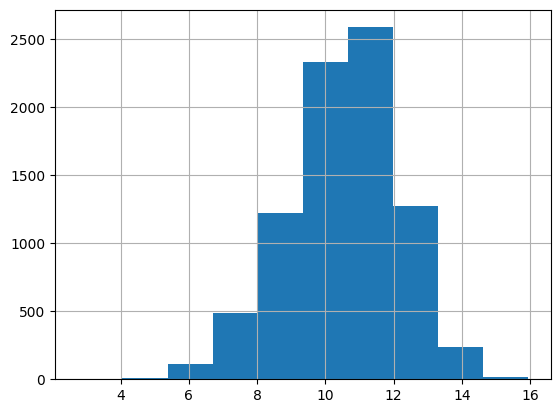

In [389]:
pd.Series(int1).hist()

<Axes: >

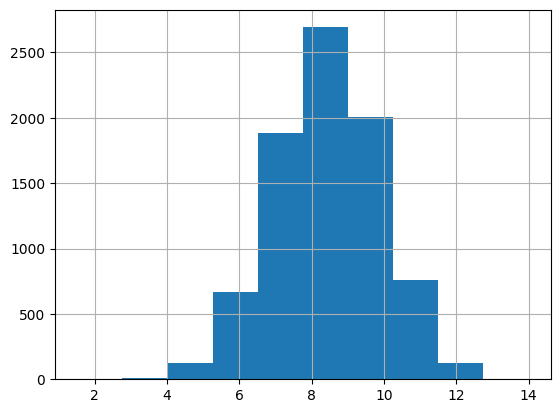

In [390]:
pd.Series(int0).hist()

In [391]:
test=X_test.copy()
test.loc[:, "TERT"] = 10
int0 = nn.predict(test)

test=X_test.copy()
test.loc[:, "TERT"] = 20
int1 = nn.predict(test)

np.mean(int1) - np.mean(int0)

3.9743439184637346

In [53]:
complete_set.head()

,originalRUN,CDKN1A,CTNNB1,IL6,LEP,MYC,STAT3,TERT,TNP,WNT3A
0,0,19.628701,16.220750,15.429706,22.468321,11.962258,13.934370,16.630116,18.695142,23.189134
1,1,14.459347,12.098472,12.972846,15.760015,9.815250,8.182938,15.468241,14.314990,12.578313
2,2,15.798020,12.599483,11.676077,16.010769,9.207679,9.072689,15.364352,14.910910,14.501268
3,3,15.982628,12.253814,11.129359,14.376379,8.514989,10.172678,12.776435,13.817769,14.350051
4,4,17.096110,13.028473,13.675179,20.191507,11.185610,11.046483,16.268359,17.397950,16.154491


(4.5, 16.5)

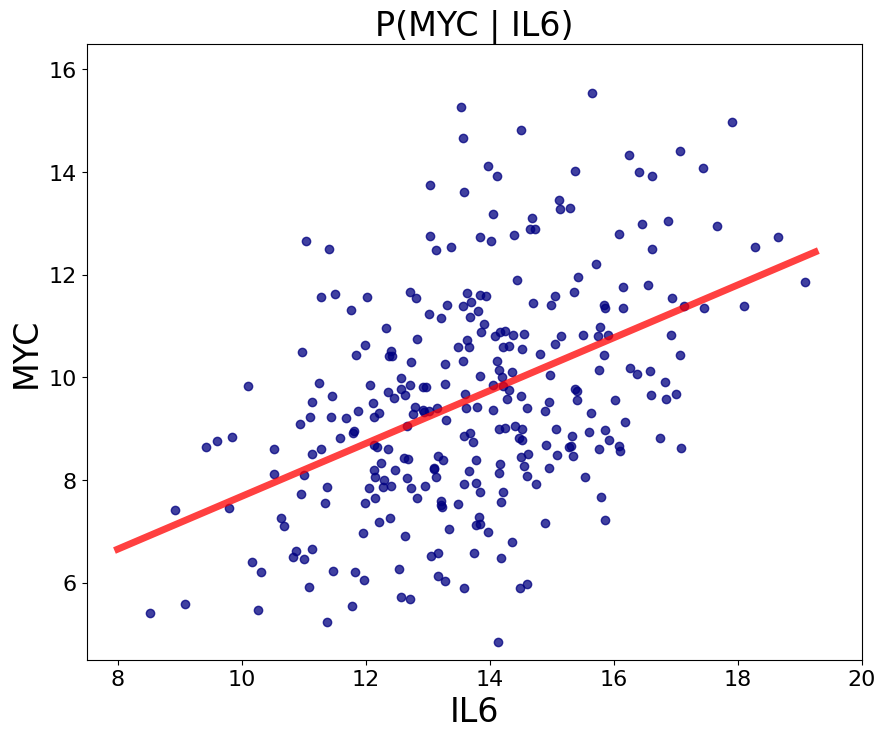

In [143]:
fig, ax = plt.subplots(figsize=(10,8))

plot_lm = linear_model.LinearRegression()
plot_lm.fit(complete_set["IL6"].values.reshape(-1, 1), complete_set["MYC"])

ax.scatter(complete_set["IL6"], complete_set["MYC"], color="navy", alpha=.75)
ax.plot(np.arange(8,19.5, .25), plot_lm.coef_[0]*np.arange(8,19.5, .25) + plot_lm.intercept_, 
        color="red", lw=5, alpha=.75)
ax.set_title("P(MYC | IL6)", size=24)
ax.set_xlabel("IL6", size=24)
ax.set_ylabel("MYC", size=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

ax.set_xlim(7.5, 20.)
ax.set_ylim(4.5, 16.5)

(5.5, 13.5)

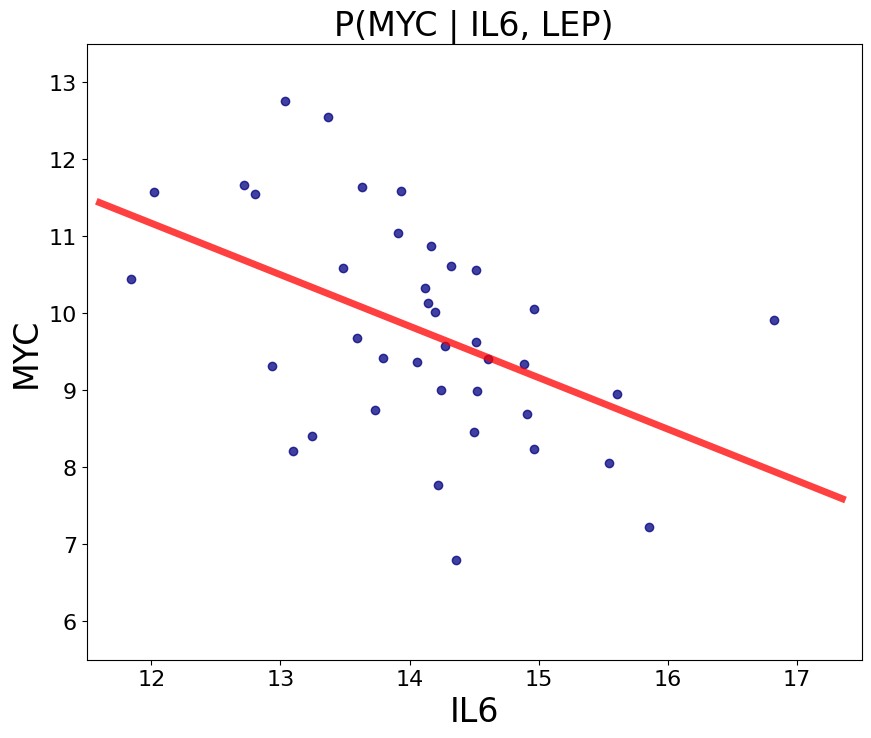

In [144]:
plot_x = complete_set.loc[complete_set["LEP"].between(18,19), "IL6"]
plot_y = complete_set.loc[complete_set["LEP"].between(18,19), "MYC"]

fig, ax = plt.subplots(figsize=(10,8))

plot_lm = linear_model.LinearRegression()
plot_lm.fit(plot_x.values.reshape(-1, 1), plot_y)

ax.scatter(plot_x, plot_y, color="navy", alpha=.75)
ax.plot(np.arange(11.6,17.5, .25), plot_lm.coef_[0]*np.arange(11.6,17.5, .25) + plot_lm.intercept_, 
        color="red", lw=5, alpha=.75)
ax.set_title("P(MYC | IL6, LEP)", size=24)
ax.set_xlabel("IL6", size=24)
ax.set_ylabel("MYC", size=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

ax.set_xlim(11.5, 17.5)
ax.set_ylim(5.5, 13.5)

In [145]:
bucket = [0, 14, 16, 18, 20, 22, np.inf]

plot_list = list()
lm_list = list()

for i in range(1, len(bucket)):

    temp_df = complete_set.loc[
        complete_set["LEP"].between(bucket[i-1], bucket[i]), 
        ["IL6", "MYC"]]
    
    temp_df.loc[:, "LEP"] = f"{bucket[i-1]}-{bucket[i]}"
    temp_df.loc[:, "test"] = i
    
    plot_list.append(temp_df)

    plot_lm = linear_model.LinearRegression()
    plot_lm.fit(temp_df["IL6"].values.reshape(-1, 1), temp_df["MYC"])
    lm_list.append(plot_lm)

plot_df = pd.concat(plot_list)
plot_df = plot_df[plot_df["test"].between(2,5)]


In [146]:
plot_df.head()

,IL6,MYC,LEP,test
1,12.972846,9.815250,14-16,2
3,11.129359,8.514989,14-16,2
7,12.139906,9.223733,14-16,2
15,10.683620,7.108725,14-16,2
17,10.945157,9.095048,14-16,2


In [153]:
temp_df = plot_df.loc[:, ["IL6", "MYC", "LEP"]]
temp_df = pd.get_dummies(temp_df)
plot_lm = linear_model.LinearRegression()
plot_lm.fit(temp_df.loc[:, ["IL6", "LEP_14-16", 
                            "LEP_16-18", "LEP_18-20", 
                            "LEP_20-22"]], temp_df["MYC"])

LinearRegression()

In [154]:
plot_lm.coef_

array([-0.4541471 , -2.21567852, -0.79129622,  1.01468553,  1.99228921])

In [156]:
temp_df = plot_df.loc[:, ["IL6", "MYC", "LEP"]]
temp_df = pd.get_dummies(temp_df)
plot_lm_one = linear_model.LinearRegression()
plot_lm_one.fit(temp_df.loc[:, ["IL6"]], temp_df["MYC"])

LinearRegression()

In [160]:
plot_lm_one.coef_[0]*np.arange(8.,17.5, .25) + plot_lm.intercept_

array([18.15950898, 18.23215651, 18.30480403, 18.37745156, 18.45009908,
       18.52274661, 18.59539413, 18.66804166, 18.74068918, 18.81333671,
       18.88598423, 18.95863175, 19.03127928, 19.1039268 , 19.17657433,
       19.24922185, 19.32186938, 19.3945169 , 19.46716443, 19.53981195,
       19.61245948, 19.685107  , 19.75775453, 19.83040205, 19.90304957,
       19.9756971 , 20.04834462, 20.12099215, 20.19363967, 20.2662872 ,
       20.33893472, 20.41158225, 20.48422977, 20.5568773 , 20.62952482,
       20.70217235, 20.77481987, 20.8474674 ])

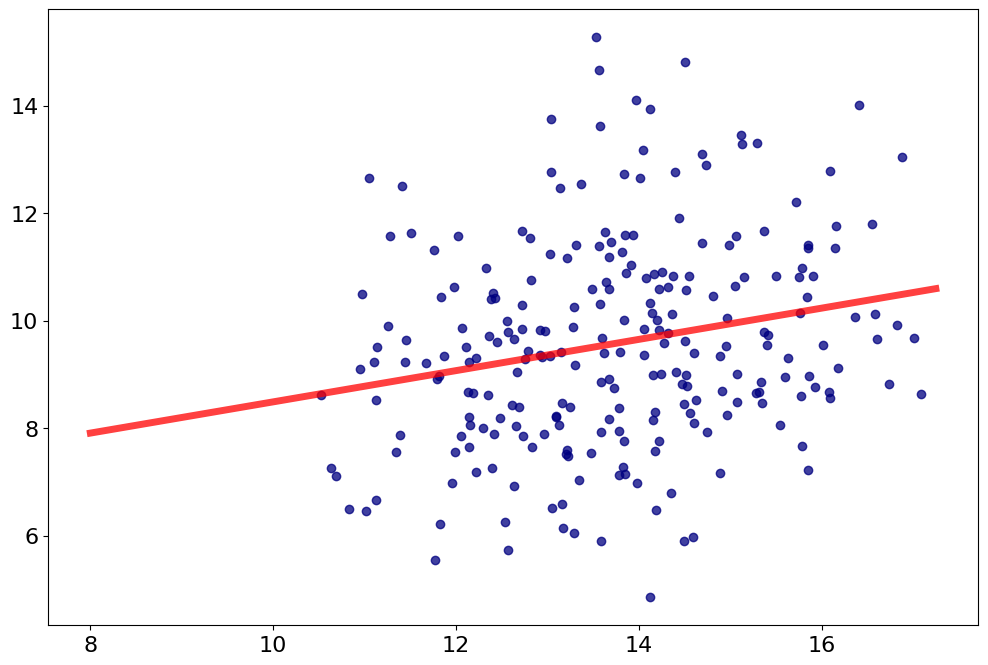

In [164]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

ax.scatter(plot_df["IL6"],  plot_df["MYC"], color="navy", alpha=.75)
# ax.plot(np.arange(8.,17.5, .25), 
#         np.repeat(1, len(np.arange(8.,17.5, .25))), lm_list[0].coef_[0]*np.arange(8.,17.5, .25) + lm_list[0].intercept_, 
#         color="red", lw=5, alpha=.75)

ax.plot(np.arange(8.,17.5, .25),  plot_lm_one.coef_[0]*np.arange(8.,17.5, .25) + plot_lm_one.intercept_, 
        color="red", lw=5, alpha=.75)

# ax.plot(np.arange(8.,17.5, .25), 
#         np.repeat(6, len(np.arange(8.,17.5, .25))), lm_list[5].coef_[0]*np.arange(8.,17.5, .25) + lm_list[5].intercept_, 
#         color="red", lw=5, alpha=.75)
# ax.set_title("P(MYC | IL6, LEP)", size=24)
# ax.set_xlabel("IL6", size=24)
# ax.set_ylabel("MYC", size=24)
# plt.rc('xtick', labelsize=16)
# plt.rc('ytick', labelsize=16)

# ax.set_xlim(11.5, 17.5)
# ax.set_ylim(5.5, 13.5)

['1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5']


[Text(1.5, 0, '15'),
 Text(2.0, 0, '16'),
 Text(2.5, 0, '17'),
 Text(3.0, 0, '18'),
 Text(3.5, 0, '19'),
 Text(4.0, 0, '20'),
 Text(4.5, 0, '21'),
 Text(5.0, 0, '22'),
 Text(5.5, 0, '')]

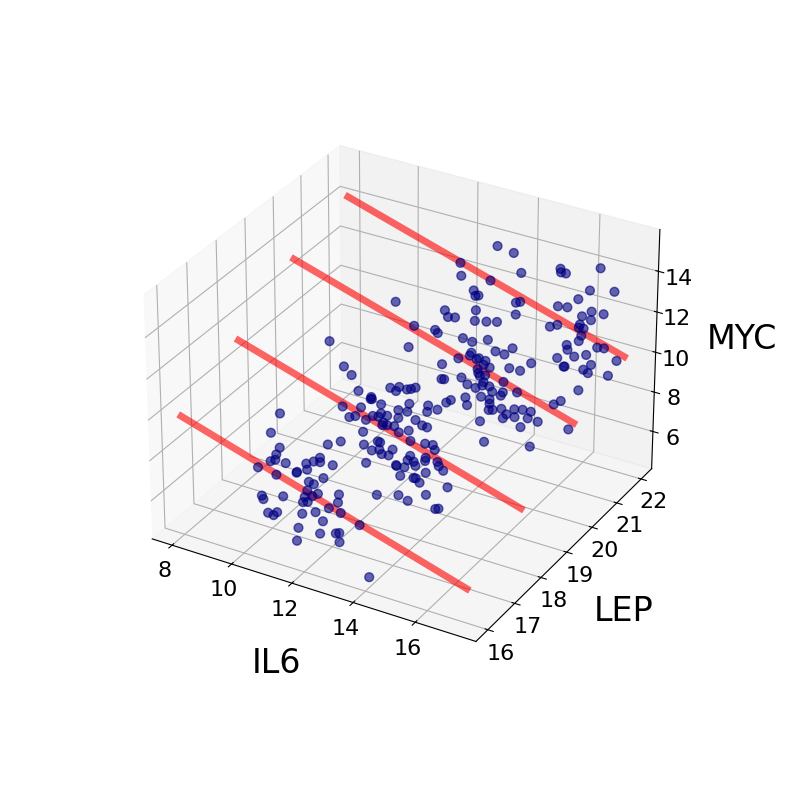

In [211]:
fig = plt.figure(figsize=(14,10), facecolor='w')
ax = fig.add_subplot(projection='3d')

ax.scatter(plot_df["IL6"], plot_df["test"], plot_df["MYC"], color="navy", alpha=.6, s=40)
# ax.plot(np.arange(8.,17.5, .25), 
#         np.repeat(1, len(np.arange(8.,17.5, .25))), lm_list[0].coef_[0]*np.arange(8.,17.5, .25) + lm_list[0].intercept_, 
#         color="red", lw=5, alpha=.75)

ax.plot(np.arange(8.,17.5, .25), 
        np.repeat(2, len(np.arange(8.,17.5, .25))), 
        plot_lm.coef_[0]*np.arange(8.,17.5, .25) + plot_lm.intercept_ + plot_lm.coef_[1], 
        color="red", lw=5, alpha=.6)

ax.plot(np.arange(8.,17.5, .25), 
        np.repeat(3, len(np.arange(8.,17.5, .25))),
          plot_lm.coef_[0]*np.arange(8.,17.5, .25) + plot_lm.intercept_ + plot_lm.coef_[2], 
        color="red", lw=5, alpha=.6)

ax.plot(np.arange(8.,17.5, .25), 
        np.repeat(4, len(np.arange(8.,17.5, .25))), 
        plot_lm.coef_[0]*np.arange(8.,17.5, .25) + plot_lm.intercept_ + plot_lm.coef_[3], 
        color="red", lw=5, alpha=.6)

ax.plot(np.arange(8.,17.5, .25), 
        np.repeat(5, len(np.arange(8.,17.5, .25))), 
        plot_lm.coef_[0]*np.arange(8.,17.5, .25) + plot_lm.intercept_ + plot_lm.coef_[4], 
        color="red", lw=5, alpha=.6)

# ax.plot(np.arange(8.,17.5, .25), 
#         np.repeat(6, len(np.arange(8.,17.5, .25))), lm_list[5].coef_[0]*np.arange(8.,17.5, .25) + lm_list[5].intercept_, 
#         color="red", lw=5, alpha=.75)
# ax.set_title("P(MYC | IL6, LEP)", size=24)
ax.set_xlabel("IL6", size=24)
ax.set_ylabel("LEP", size=24)
ax.set_zlabel("MYC", size=24)
# plt.rc('xtick', labelsize=16)
# plt.rc('ytick', labelsize=16)
ax.xaxis.labelpad=30
ax.yaxis.labelpad=30
ax.zaxis.labelpad=30
ax.set_box_aspect(aspect=None, zoom=0.75)

labels = [item.get_text() for item in ax.get_yticklabels()]
print(labels)

labels = ['15', '16', '17', '18', '19', '20', '21', '22', '']

ax.set_yticklabels(labels)

# ax.set_xlim(11.5, 17.5)
# ax.set_ylim(5.5, 13.5)

In [210]:
import plotly.graph_objects as go
import numpy as np

x=plot_df["IL6"]
y=plot_df["test"]
z=plot_df["MYC"]

fig = go.Figure(
    data=[go.Scatter3d(z=z, x=x, y=y, opacity=0.5)])
fig.update_layout(
    title='My title', 
    autosize=True,
    width=500, 
    height=500,
)
fig.show()

<Axes: >

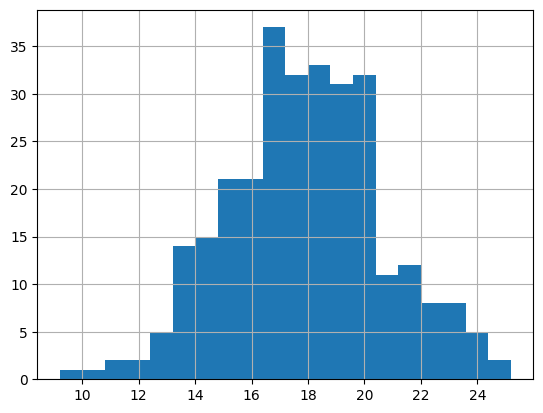

In [59]:
complete_set["LEP"].hist(bins=20)

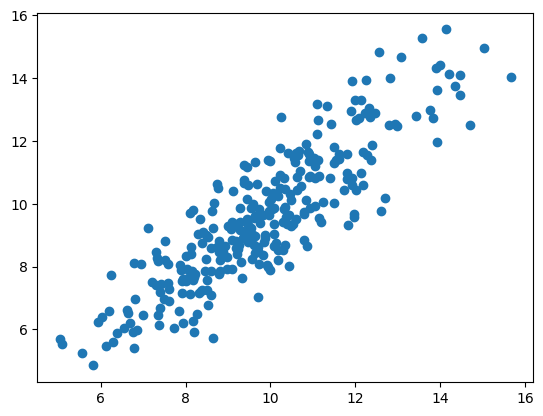

In [55]:
fig, ax = plt.subplots()

ax.scatter(complete_set["STAT3"], complete_set["MYC"])

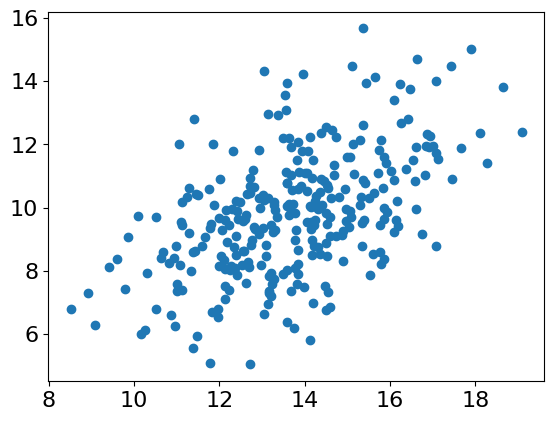

In [97]:
fig, ax = plt.subplots()

ax.scatter(complete_set["IL6"], complete_set["STAT3"])